In [1]:
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd


# Seed para que las redes con iguales parametros no generen resultados aleatorios y tener repetibilidad
np.random.seed(42)
tf.random.set_seed(42)

# Para las graficas
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

#Función para plotear
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

#Función Rounded Accuracy
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

    
#Traemos los datos de Fashion MNIST
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full_normalized = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full_normalized[:-5000], X_train_full_normalized[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

#Función para ver los resultados de las reconstrucciones
def show_reconstructions(model, images=X_test, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])
        
#Función para ver los resultados de las reconstrucciones en el modelo con 2 salidas
def show_reconstructions_class(model, images=X_test, n_images=5):
    reconstructions,_ = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])
        
#Función para visualziar multiples imagenes generadas por las GANs o VAEs        
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

2024-04-04 20:49:19.694152: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-04 20:49:19.694264: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-04 20:49:19.886049: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


**Difinición y Entrenamiento**

In [3]:
#Definimos la red GAN
#Seed para el factor aleatorio
tf.random.set_seed(42)
np.random.seed(42)

#Esta variable marca el shape del input del generador
codings_size = 100

#Definimos el generador como un modelo secuencial
generator = keras.models.Sequential([
    keras.layers.InputLayer(shape=[codings_size]),
    keras.layers.Dense(7 * 7 * 128),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100,activation="relu",kernel_initializer="HeNormal"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
                                 activation="relu",kernel_initializer="HeNormal"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME",
                                 activation="tanh"),
])

#Definimos el discriminador como un modelo secuencial
discriminator = keras.models.Sequential([
    keras.layers.InputLayer(shape=[28, 28, 1]),
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation="relu"),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation="relu"),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])

#Creamos el modelo GAN juntanto del generador y el discriminador
gan = keras.models.Sequential([generator, discriminator])

In [4]:
#Definimos una función para realizar el entrenamiento de la GAN considerando la competencia entre el generador y el discriminador
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=5):
    generator, discriminator = gan.layers
    #Para graficar el loss cree estas 2 listas
    discriminator_loss=[]
    generator_loss=[]
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))
        for i_,X_batch in enumerate(dataset):
            print(f'\r{i_+1}/{round(X_train.shape[0]/X_batch.shape[0])}',end='')
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            #Guardo en una variable porque train_on_batch retorna el valor del loss para ese batch
            x=discriminator.train_on_batch(X_fake_and_real, y1)
            #Y ese valor guardado lo meto a la lista que va a usar para graficar el loss
            discriminator_loss.append(x)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            #Similar al discriminador, guardo el return de train_on_batch 
            x=gan.train_on_batch(noise, y2)
            #Y lo agrego a la lista de los losses para graficarlos
            generator_loss.append(x)
        #Mostramos los valores actuales de loss para cada parte del modelo
        print(" Discriminator loss: ",discriminator_loss[-1],". Generator_loss: ",generator_loss[-1])
    #Ploteo 6 imagenes generadas pero solo al final para reducir el espacio usado por la celda de entrenamieno
    plot_multiple_images(generated_images, 6)
    plt.show()
    #Retorno las listas con los losses para hacer las gráficas
    return discriminator_loss,generator_loss

#Definimos el optimzador para customizar el learning rate
#Compilamos el discriminador para modificar su parametro trainable y que solo se entrene cuando se llame directamente su fit 
#o train_on_batch y no al entrenar el GAN completo, si se llama el fit de GAN solo se entrena el generador
discriminator.compile(loss="binary_crossentropy", optimizer=keras.optimizers.RMSprop(learning_rate=0.9))
discriminator.trainable = False
#Compilamos el GAN
gan.compile(loss="binary_crossentropy", optimizer=keras.optimizers.RMSprop(learning_rate=0.9))#Aparntemente va bien pero necesitaria las 10 epocas y ver que pasa, igual demosle la chance y se le pude acomodar el lr

#Siguen un par de procesos para organizar las imagenes de muestra antes de entregarselas al modelo

#Reshape de las imagenes de fashion MNIST guardadas en X_train para que esten centradas en 0 
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. 
#Definimos el batch_size que se va a usar en el entrenamiento
batch_size = 64
#Se crea un dataset para generar los batches usando las imagenes con reshape
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
#Se le hace shuffle para evitar que el modelo aprenda de un patron secuencial
dataset = dataset.shuffle(1000)
#Y finalmente se crean los batches con el size que ya se indico y eliminando los elemenos del dataset que queden
#sobrantes
#Tambien se usa prefetch para aumentar la eficiencia del modelo preparando las imagenes para el proximo train step
#mientras se sigue ejecutando el actual
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [5]:
#Clear session para no conservar datos de entrenamientos pasados
keras.backend.clear_session()

#Con todo lo anterior ya podemos llamar la función train y entrenar el modelo
#Recordamos que train_gan retorna 2 listas con los losses que podemos usar para graficar su evolución
loss_1,loss_2=train_gan(gan, dataset, batch_size, codings_size,n_epochs=30)

Epoch 1/30
1/859

I0000 00:00:1712262344.286835      86 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1712262351.083331      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


859/859 Discriminator loss:  33668.547 . Generator_loss:  35706.508
Epoch 2/30
859/859 Discriminator loss:  16834.277 . Generator_loss:  17853.258
Epoch 3/30
419/859

KeyboardInterrupt: 

**Evolución del loss**

In [ ]:
plt.plot(loss_1,label="Discriminator Loss")
plt.plot(loss_2,label="Generator Loss")
plt.grid(True)
#plt.xlim(0,20)
#plt.ylim(0,1.5)
plt.legend()
plt.show()

**Predicción y visualización de resultados**

In [ ]:
#Otra vez la seed para el tf.random
tf.random.set_seed(42)
np.random.seed(42)

#Le entregamos ruido al generador para que nos muestre que imagenes genera a partir de ese ruido
noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
#Graficamos las imagenes generadas por el generador
plot_multiple_images(generated_images, 8)

**Discusión**
* Este modelo es increiblemente pesado de ejecutar. Consume tantos recursos que lo máximo que me permite la RAM de kaggle son 10 epocas y tengo que reiniciar l sesión porque la RAM queda llena y no se como vaciarla.
* El problema de ejecutar pocas epocas es que no hay mucho margen para ver la mejora del modelo y los tiempos de ejecución siempre son muy elevados, 

# Pruebas

In [7]:
keras.backend.clear_session()

In [2]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 100

generator = keras.models.Sequential([
    keras.layers.InputLayer(shape=[codings_size]),
    keras.layers.Dense(7 * 7 * 128),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
                                 activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME",
                                 activation="tanh"),
])
discriminator = keras.models.Sequential([
    keras.layers.InputLayer(shape=[28, 28, 1]),
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [3]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=5):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))
        for i_,X_batch in enumerate(dataset):
            print(f'\r{i_+1}/{round(X_train.shape[0]/X_batch.shape[0])}',end='')
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images, 8)
        plt.show()

In [4]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. # reshape and rescale

batch_size = 64
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

Epoch 1/30
1/859

I0000 00:00:1712263847.411063      87 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1712263853.231126      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


859/859

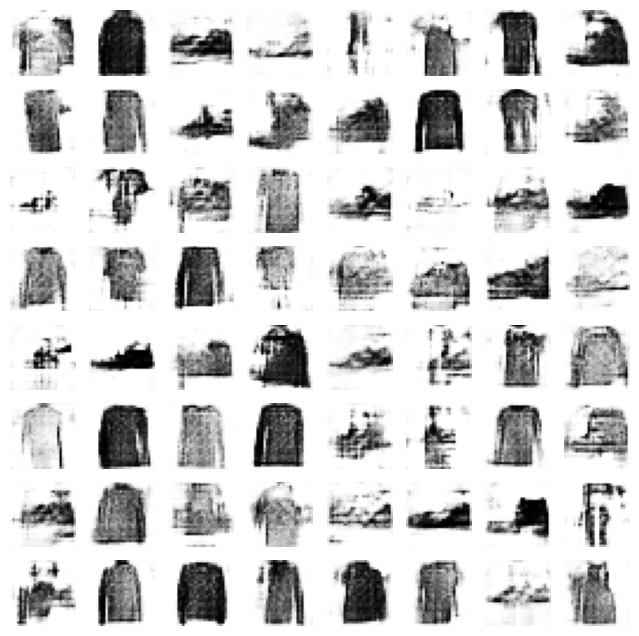

Epoch 2/30
859/859

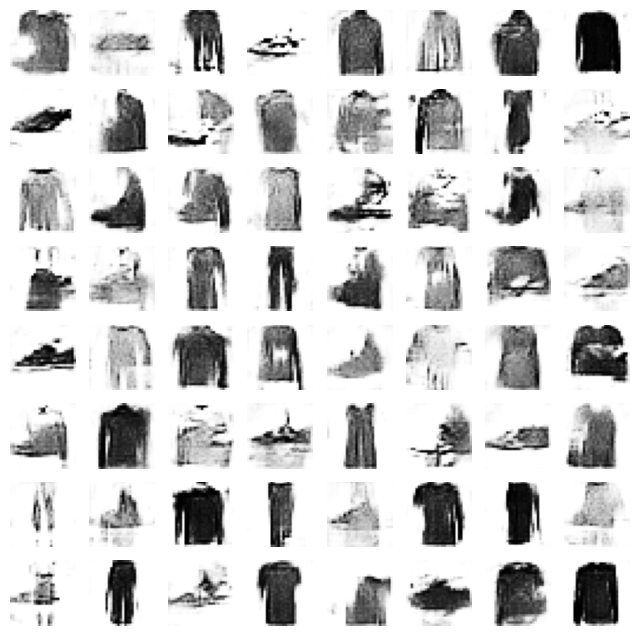

Epoch 3/30
791/859

In [ ]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=30)